$\newcommand{\xv}{\mathbf{x}}
\newcommand{\Xv}{\mathbf{X}}
\newcommand{\yv}{\mathbf{y}}
\newcommand{\Yv}{\mathbf{Y}}
\newcommand{\zv}{\mathbf{z}}
\newcommand{\av}{\mathbf{a}}
\newcommand{\Wv}{\mathbf{W}}
\newcommand{\wv}{\mathbf{w}}
\newcommand{\tv}{\mathbf{t}}
\newcommand{\Tv}{\mathbf{T}}
\newcommand{\ev}{\mathbf{e}}
\newcommand{\Ev}{\mathbf{E}}
\newcommand{\Rv}{\mathbb{R}}
\newcommand{\Av}{\mathbf{A}}
\newcommand{\vv}{\mathbf{v}}
\newcommand{\Iv}{\mathbf{I}}
\newcommand{\fv}{\mathbf{f}}
\newcommand{\norm}[1]{\left\lVert#1\right\rVert}
\newcommand{\muv}{\boldsymbol{\mu}}
\newcommand{\sigmav}{\boldsymbol{\sigma}}
\newcommand{\phiv}{\boldsymbol{\phi}}
\newcommand{\Phiv}{\boldsymbol{\Phi}}
\newcommand{\Sigmav}{\boldsymbol{\Sigma}}
\newcommand{\Lambdav}{\boldsymbol{\Lambda}}
\newcommand{\half}{\frac{1}{2}}
\newcommand{\argmax}[1]{\underset{#1}{\operatorname{argmax}}}
\newcommand{\argmin}[1]{\underset{#1}{\operatorname{argmin}}}$

# Assignment 1: Stochastic Gradient Descent for Simple Models

Lucas Wilson

## Overview

In this assignment, we learned how to use Jupyter, Numpy and some multidimensional calculus used to solve min-max problems. 

SGD works by assuming the error function is smooth with respect to its parameters. Then, creating a good model depends on our ability to minimize the error function with respect to those parameters. Since we assume it's smooth, the gradient tells us how tuning the parameters will increase or decrease the error. Since want to minimize the error, we move the parameters in the direction which has a negative gradient. Then, the error decreases.

I use the following definitions:

1. For $\xv\epsilon\Rv^n$, $\big[\xv\big]_i$ is the $i^\text{th}$ entry of the vector $\xv$.
1. For $\xv\epsilon\Rv^n$, I define $diag$ in the following way:

    $$
    \big[diag(\xv)\big]_{ij} = 
    \begin{cases} 
          x_i & i = j \\
          0 & i \ne j \\
    \end{cases}.
    $$

    In other words, the entries of the vector are along the diagonal of the diagonal matrix.

1. $\nabla \fv(\xv) = \nabla_\xv \fv = \frac{\partial \fv(\xv)}{\partial \xv}$ is the gradient of the vector $\fv$ where $\fv:\Rv^m\rightarrow\Rv^n$ and $x \epsilon \Rv^m$. In other words, the Jacobian matrix of $\fv$.
1. Standard functions, like $\tanh$, acting on vectors are distributed to each individual entry of the vector. In other words, $\big[\tanh(\xv)\big]_i = \tanh(x_i)$.
1. Notice then that the jacobian of such a function is a diagonal matrix.

    $$
    \nabla_\xv \fv = diag\big(f'(\xv)\big)
    $$

1. A component wise vector product $\wv\Xv = diag(\wv)\times\Xv$. Assume matrix multiplication unless otherwise stated.
1. The linear model is linear and not generally affine.

The typical steps for this kind of modeling is (1) to find and define a model, (2) define the error function, (3) find the derivatives of the error function with respect to the parameters of the model, (4) update the parameters accordingly to reduce the error. In this case, (4) is SGD, explained below.

## Linear Model

For our model, we have $\Yv(\Xv) = \Xv \wv$. We define our error to be $E(\Xv) = \norm{\Tv-\Yv(\Xv)}^2_2$. 
Then, to perform stochastic gradient descent, we initialize $\wv$ randomly and update it with the following:

$\wv_{k+1} = \wv_k - \eta \nabla_{\wv_k} E(X)$

Note: normally in SGD, the weights are updated per sample, but here we use all samples to update the weights. It's known as batching, and it's faster (and easier). It's more practical when you have lots of samples, in which case you actually use mini batching where $\Xv$ is split into batches.

$$
\begin{align*}
\nabla_{\wv_k} E(X) &= \frac{\partial E}{\partial \wv_k} \\
&= \frac{\partial}{\partial \wv_k} \norm{\Tv-\Yv}^2_2 \\
&= \sum_i \frac{\partial}{\partial \wv_k} (\Tv-\Yv)^2_i \\
&= \sum_i -2(\Tv-\Yv)_i \frac{\partial \Yv_i}{\partial \wv_k}  \\
&= \sum_i -2(\Tv-\Yv)_i \frac{\partial}{\partial \wv_k} (\Xv \wv_k)_i \\
&= \sum_i -2(\Tv-\Yv)_i (\frac{\partial}{\partial \wv_k} \Xv \wv_k)_i \text{, since partials distribute across vectors,} \\
&= \sum_i -2(\Tv-\Yv)_i \Xv_i \text{, where } X_i = i^{\text{th}}\text{ row vector of } X \text{ and since } \frac{\partial}{\partial \xv} \Av \xv=\Av \\
&= -2 \sum_i \Xv_i (\Tv-\Yv)_i \\
&= -2 \Xv^T (\Tv-\Yv) \text{, by definition of dot product (which still applies despite X being a matrix: in this case, X is seen as a vector of vectors).} \\
\end{align*}
$$

Since $\eta>0$ is arbitrary, the $\wv$ update simplifies to the following:

$$
\wv_{k+1} = \wv_k + \eta \Xv^T (\Tv-\Yv)
$$

In [1]:
def train_linear(X, T, learning_rate, number_of_iterations):
    """
    * `X` is a two-dimensional matrix (`np.array`) with each row containing one data sample
    * `T` is a two-dimensional matrix of one column containing the target values for each sample in `X`. `X.shape[0]` is equal to `T.shape[0]`
    * `learning_rate` is the factor multiplying the negative derivative
    * `number_of_iterations` is the number of update steps to take
    * `model` is the two-dimensional matrix of one column containing the resulting weights
    """
    model = np.random.rand(X.shape[1], 1)
    for _ in range(number_of_iterations):
        Y = use_linear(model, X)
        gradient = X.T@(T-Y)
        model = model + learning_rate*gradient
    return model
    
def use_linear(model, X):
    """
    * `X` is a two-dimensional matrix (`np.array`) with each row containing one data sample
    * `model` is the result of a call to `train_linear`
    * `predict` is a two-dimensional matrix of one column containing the predicted values for each value in `T`
    """
    return X@model

def rmse(predict, T):
    """ 
    * `T` is a two-dimensional matrix of one column containing the target values for each sample in `X`
    * `predict` is the result of a call to `use_linear(model, X)`
    * `error` is the square root of the mean of the squared error between `predict` and `T`
    """
    return np.sqrt(np.mean((predict-T)**2))
    

## Tanh Model

Similar to before, we have $\Yv(\Xv) = \tanh(\Xv \wv)$, where $\tanh(\xv)_i = \tanh(\xv_i) $. We define our error to be $E(\Xv) = \norm{\Tv-\Yv}^2_2$. 
Then, to perform stochastic gradient descent, we initialize $\wv$ randomly and update it with the following:

$\wv_{k+1} = \wv_k - \eta \nabla_{\wv_k} E(X)$

$$
\begin{align*}
\nabla_{\wv_k} E(X) &= \frac{\partial E}{\partial \wv_k} \\
&= \frac{\partial}{\partial \wv_k} \norm{\Tv-\Yv}^2_2 \\
&= \sum_i \frac{\partial}{\partial \wv_k} (\Tv-\Yv)^2_i \\
&= \sum_i -2(\Tv-\Yv)_i \frac{\partial \Yv_i}{\partial \wv_k}  \\
&= \sum_i -2(\Tv-\Yv)_i \frac{\partial}{\partial \wv_k} \tanh(\Xv \wv_k)_i \\
&= \sum_i -2(\Tv-\Yv)_i (\frac{\partial}{\partial \wv_k} \tanh(\Xv \wv_k))_i \text{, since partials distribute across vectors,} \\
&= -2 \big(\frac{\partial}{\partial \wv_k} \tanh(\Xv \wv_k)\big)^T (\Tv-\Yv) \text{, by definition of dot product (see linear model).} \\
\end{align*}
$$

Now, we need to know what $\frac{\partial}{\partial \wv_k} \tanh(\Xv \wv_k)$ is.

$$
\begin{align*}
\frac{\partial}{\partial \wv_k} \tanh(\Xv \wv_k) &= \big[\frac{\partial}{\partial (\Xv\wv_k)}\tanh(\Xv \wv_k)\big] \big[\frac{\partial }{\partial \wv_k}\Xv\wv_k\big] \\
&= \big[\frac{\partial}{\partial (\Xv\wv_k)}\tanh(\Xv \wv_k)\big] \Xv \text{, since } \frac{\partial}{\partial \xv} \Av \xv=\Av \\
&= \big[\frac{\partial}{\partial \vv}\tanh(\vv)\big] \Xv \text{, where } \vv \text{ is a column vector,} \\
\end{align*}
$$

$\tanh: \Rv^n \rightarrow \Rv^n$ and $\tanh_i$ depends only on $\vv_i$, $\big[\tanh(\vv)\big]_i = \tanh(\vv_i)$, so it follows that
$$
\frac{\partial}{\partial \vv}\tanh(\vv) = diag\big(1-\tanh(\vv)\big) = \Iv-diag\big(\tanh(\vv)\big)
$$
where $diag\big(1-\tanh(\vv)\big)$ is the diagonal matrix with entries of $1-\tanh(\vv_i)$ for all $i$ along the diagonal.

See definitions 3-5 for a better explanation of these definitions I am using.

Then,
$$
\begin{align*}
\frac{\partial}{\partial \wv_k} \tanh(\Xv \wv_k) &= \Big(\Iv - diag\big(\tanh(\Xv \wv_k)\big) \Big)\Xv \\
&= \big(\Iv - diag(\Yv) \big)\Xv \\
\end{align*}
$$

Then,
$$
\begin{align*}
\nabla_{\wv_k} E(X) &= -2 \big(\frac{\partial}{\partial \wv_k} \tanh(\Xv \wv_k)\big)^T (\Tv-\Yv) \\
&= -2 \Big(\big(\Iv - diag(\Yv) \big)\Xv\Big)^T (\Tv-\Yv) \\
\end{align*}
$$

Again, since $\eta>0$ is arbitrary, the $\wv$ update simplifies to the following:

$$
\wv_{k+1} = \wv_k + \eta \Big(\big(\Iv - diag(\Yv) \big)\Xv\Big)^T (\Tv-\Yv)
$$

Implemented in python, this is much easier to understand:

    w = w + eta * ( (1-Y)*X ).T @ (T-Y)

In [2]:
def train_tanh(X, T, learning_rate, number_of_iterations):
    """
    * `X` is a two-dimensional matrix (`np.array`) with each row containing one data sample
    * `T` is a two-dimensional matrix of one column containing the target values for each sample in `X`. `X.shape[0]` is equal to `T.shape[0]`
    * `learning_rate` is the factor multiplying the negative derivative
    * `number_of_iterations` is the number of update steps to take
    * `model` is the two-dimensional matrix of one column containing the resulting weights
    """
    model = np.random.rand(X.shape[1], 1)
    for _ in range(number_of_iterations):
        Y = use_tanh(model, X)
        gradient = ((1-Y)*X).T@(T-Y)
        model = model + learning_rate*gradient
    return model

def use_tanh(model, X):
    return np.tanh(X@model)

## Testing

In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def test(title, X, T, linear_model=None, tanh_model=None, eta=0.01, trials=10000):
    # training
    if linear_model is None:
        linear_model = train_linear(X, T, eta, trials)
    
    if tanh_model is None:
        tanh_model = train_tanh(X, T, eta, trials)
    
    # plotting
    plt.figure(figsize=(15, 3))
    
    plt.subplot(1, 4, 1)
    plt.ylabel(title)
    plt.xlabel('actual')
    plt.plot(T, 'o')
    
    plt.subplot(1, 4, 2)
    plt.xlabel('linear model (rmse: {:.3f})'.format(rmse(use_linear(linear_model, X), T)))
    plt.plot(use_linear(linear_model, X), 'r-')
    
    plt.subplot(1, 4, 3)
    plt.xlabel('tanh model (rmse: {:.3f})'.format(rmse(use_tanh(tanh_model, X), T)))
    plt.plot(use_tanh(tanh_model, X), 'g-')
    
    plt.subplot(1, 4, 4)
    plt.xlabel('all models')
    plt.plot(T, 'o')
    plt.plot(use_linear(linear_model, X), 'r-')
    plt.plot(use_tanh(tanh_model, X), 'g-')
    
    plt.tight_layout()

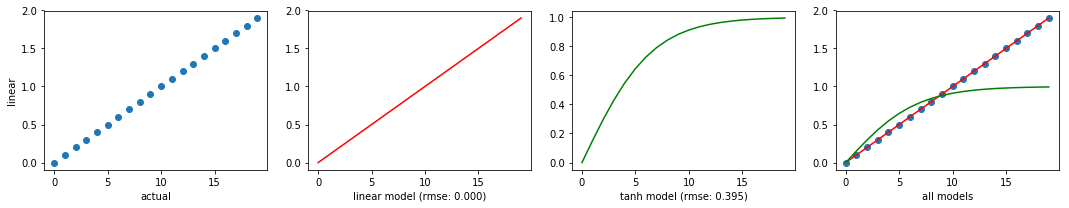

In [4]:
X = (np.arange(20) * 0.1).reshape((-1,1))
test('linear', X, X)

The linear model is capable of fitting linear data, go figure. The tanh is at least on track.

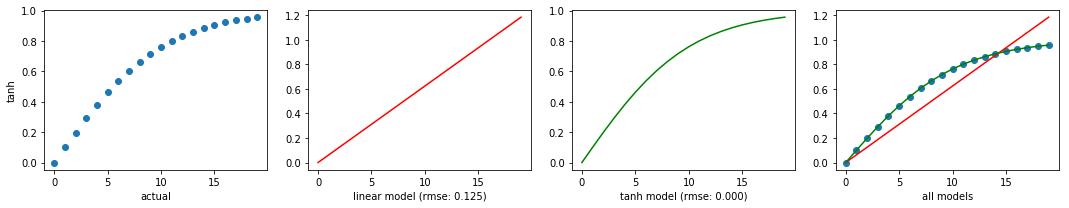

In [5]:
X = (np.arange(20) * 0.1).reshape((-1,1))
test('tanh', X, np.tanh(X))

The tanh model likewise fits a tanh curve

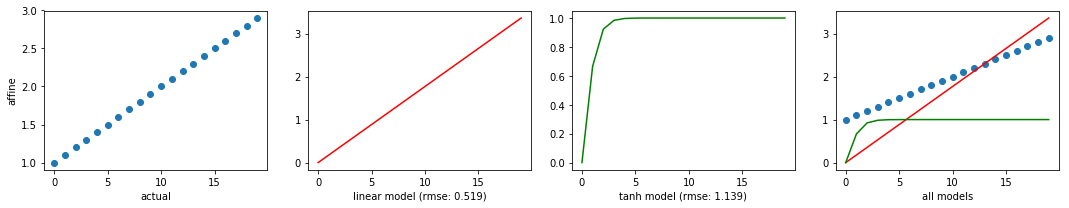

In [6]:
X = (np.arange(20) * 0.1).reshape((-1,1))
test('affine', X, X+1)

This function is affine, not linear. Since our linear model is not affine, it can't fit it. Tanh doesn't do too well either, but this makes sense since it's range is $\tanh(\Rv)=[-1, 1]$, so it isn't capable of fitting this data.

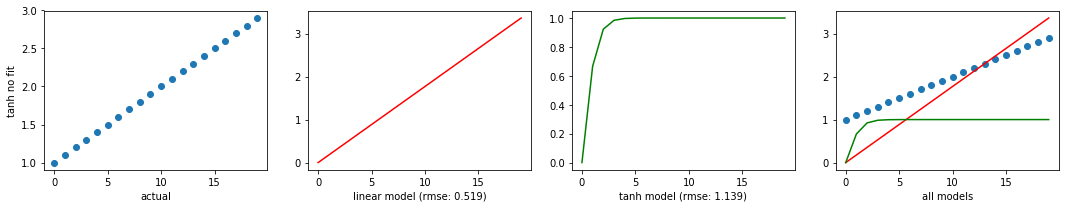

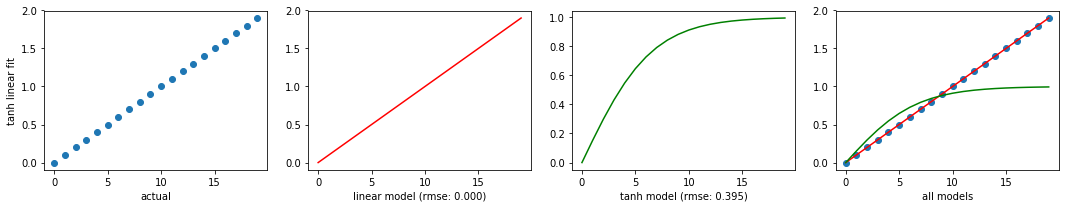

In [7]:
X = (np.arange(20) * 0.1).reshape((-1,1))
tanh_model_gto = train_tanh(X, X+1, 0.001, 100000)
tanh_model = train_tanh(X, X, 0.001, 100000)
test('tanh no fit', X, X+1, tanh_model=tanh_model_gto)
test('tanh linear fit', X, X, tanh_model=tanh_model)

The 'tanh no fit' set won't work because of tanh's range. Instead the model maximizes its outputs to be as close to the data as possible. With the second graph, it's interesting to see that even with excessive training, the tanh model can't fit linear very well. This is probably because it is composed of exponential functions which are of a very different order of magnitude. 

no train RMSE: 1.4694336798725316
train RMSE: 0.07303474422860205


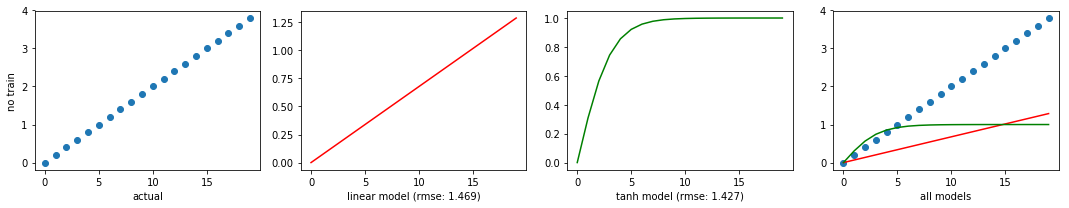

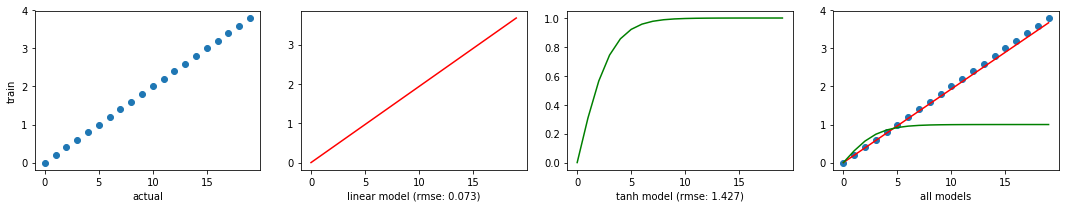

In [8]:
X = (np.arange(20) * 0.1).reshape((-1,1))
T = 2*X

no_train = train_linear(X, T, 0.01, 1)
train = train_linear(X, T, 0.01, 10)
test('no train', X, T, linear_model=no_train)
print("no train RMSE:", rmse(use_linear(no_train, X), T))
test('train', X, T, linear_model=train)
print("train RMSE:", rmse(use_linear(train, X), T))

You can see from the graphs and rmse that with less training the model is worse. Of course, this is obvious, but it shows my trainers are working.

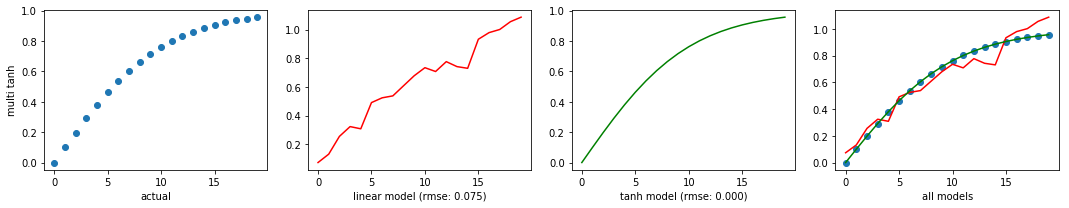

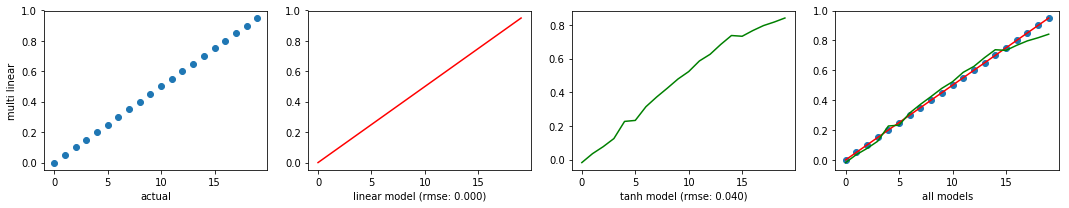

In [9]:
X = (np.arange(20) * 0.1).reshape((-1,1))
Xmulti = np.random.rand(20, 5) # add noise
Xmulti[:, 0] = X[:, 0] # 
TmultiTanh = np.tanh(Xmulti[:, 0:1]) # use first row to generate data
TmultiLinear = Xmulti[:, 0:1] # use first row to generate data
test('multi tanh', Xmulti, TmultiTanh)
test('multi linear', Xmulti, TmultiLinear/2) # /2 so tanh has a chance to fit it

After seeing the results of the first graph, I repeated the test with the linear model.

This one did something I wasn't expecting. The linear model doesn't look linear.

These graphs are different since it uses a multidimensional input instead of a vector. I added random noise in the extra dimensions, and the output depends only on the first row. A good model should figure that out and ignore the noise. $\tanh$ does exactly that, and in the end fits the data perfectly. However, the linear model uses the noise to instead fit better than it would.

What I didn't expect, the linear model used the noise to stop being linear and actually fit the data better. From above, the linear model has a RSME of 0.125 fitting tanh models, but this one has much less. We know it's over-fitting, so it might not be useful, but it'd be interesting to see what other models can benefit from added random noise for the model to use at its disposal (e.g., simulating noise).

In the second experiment, the actual model is linear, so linear is a perfect fit. Now, tanh can't fit perfectly, but it still is capable of deviating from it's shape to fit linear pretty well.

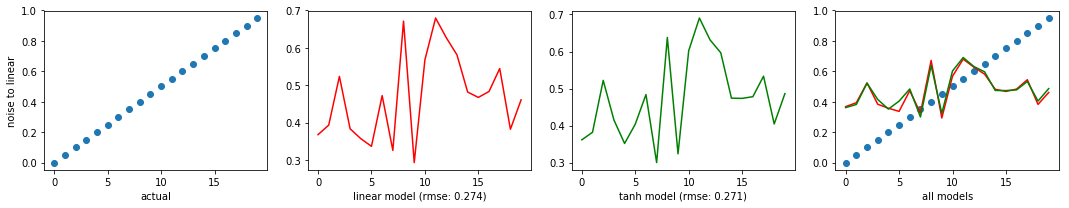

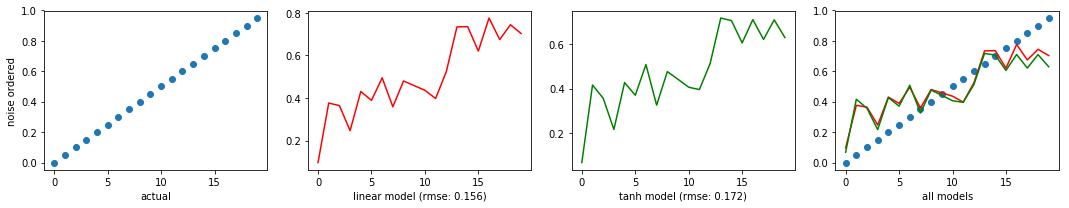

In [10]:
Xmulti = np.random.rand(20, 5)
Tmulti = (np.arange(20)*.05).reshape(-1, 1)
test('noise to linear', Xmulti, Tmulti, eta=0.001, trials=100000)
order = np.argsort(np.mean(Xmulti, axis=1)).reshape(-1)
test('noise ordered', Xmulti[order], Tmulti)

In the first graph, I fed it pure noise hoping it would overfit, but I actually have no idea what's happening. Both models are initialized with different but random weights, yet they both converge to the same wrong answer. I wasn't expecting them to converge to the solution, but I especially wasn't expecting them to look the same.

The second graph shows what happens when you sort the noise by its mean, so it's kind of in ascending order. All the model has to do is pick up on this fact. It generally does fit the data, so I think it was successful, interestingly. At least, the RSME is smaller.

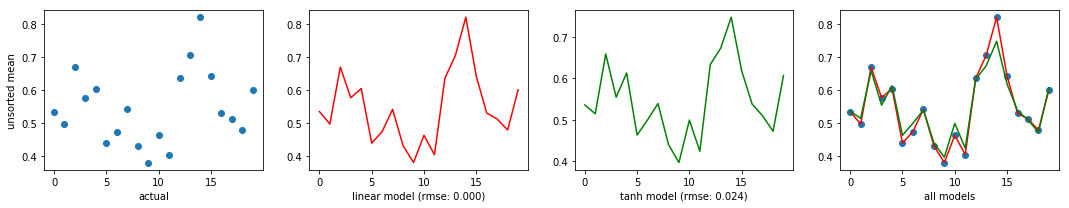

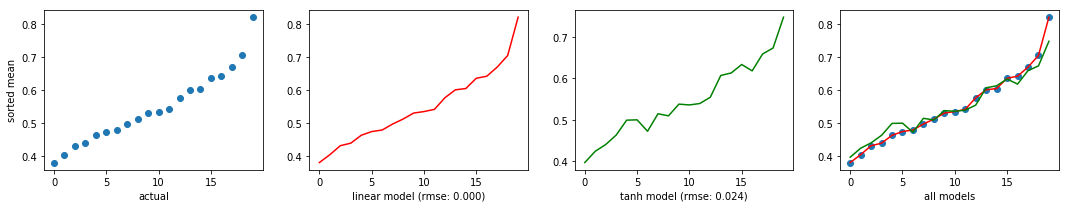

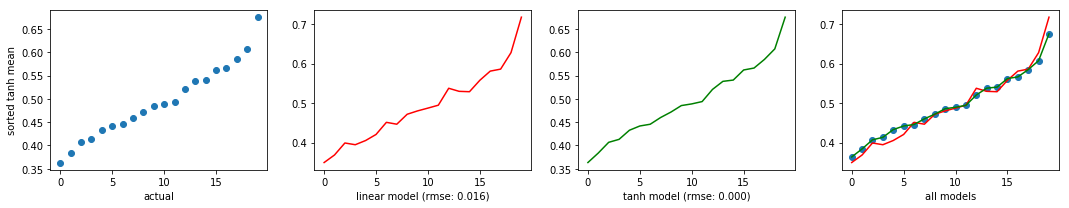

In [11]:
X = np.random.rand(20, 5)
T = np.mean(X, axis=1).reshape(-1, 1)
order = np.argsort(T, axis=0).reshape(-1)
test('unsorted mean', X, T)
test('sorted mean', X[order], T[order])
test('sorted tanh mean', X[order], np.tanh(T[order]))

This model actually makes the target be the mean of noise. Three observations here:
* Even though the data isn't continuous, the models are smart enough to not care. Both fit very nicely.
* Taking a mean is a linear combination, and therefore the linear model is capable of fitting perfectly. My trainer does converge to this solution, which is good.
* In the third graph, we can see tanh even converges to this perfectly.

## Grading

Your notebook will be run and graded automatically.  Test this grading process by first downloading [A1grader.tar](http://www.cs.colostate.edu/~anderson/cs445/notebooks/A1grader.tar) and extract `A1grader.py` from it. Run the code in the following cell to demonstrate an example grading session.  You should see a perfect execution score of 80 out of 80 points if your functions are defined correctly. The remaining 20 points will be based on the results you obtain from the energy data and on your discussions.

For the grading script to run correctly, you must first name this notebook as 'Lastname-A1.ipynb' with 'Lastname' being your last name, and then save this notebook.

A different, but similar, grading script will be used to grade your checked-in notebook.  It will include additional tests.  You need not include code to test that the values passed in to your functions are the correct form.  

In [12]:
%run -i "A1grader.py"  # not yet available!!

ERROR:root:File `'A1grader.py'` not found.


## Check-in

Do not include this section in your notebook.

Name your notebook ```Lastname-A1.ipynb```.  So, for me it would be ```Anderson-A1.ipynb```.  Submit the file using the ```Assignment 1``` link on [Canvas](https://colostate.instructure.com/courses/41327).

Grading will be based on 

  * correct behavior of the required functions listed above,
  * easy to understand plots in your notebook,
  * readability of the notebook,
  * effort in making interesting observations, and in formatting your notebook.

## Extra Credit

Define two new functions to handle the logistic, or sigmoid, function model, 

$$ \Yv = \frac{1}{1 + e^{- \Xv \wv}} $$

By this point, we can jump to this step:

$$\wv_{k+1} = \wv_k - \eta \nabla_{\wv_k} E(X)$$
and 

$$
\nabla_{\wv_k} E(X) = -2 \big(\frac{\partial }{\partial \wv_k} \frac{1}{1 + e^{- \Xv \wv_k}} \big)^T (\Tv-\Yv).
$$

Then, it follows that:

$$
\begin{align*}
\frac{\partial}{\partial \wv} \frac{1}{1 + e^{- \Xv \wv}} &= \frac{\partial}{\partial \wv}\big(1+e^{-\Xv\wv}\big)^{-1} \\
&= diag\Big(\big(1+e^{-\Xv\wv}\big)^{-2}e^{-\Xv\wv}\Big)\Xv \\
&= diag\big(\Yv^2 e^{-\Xv\wv}\big)\Xv \\
\end{align*}
$$

where every operation within the diag function except $\Xv\wv$ is a component wise operator.

In python:

    (Y * Y * np.exp(-X@model))*X

In [13]:
def train_sigmoid(X, T, learning_rate, number_of_iterations):
    """
    * `X` is a two-dimensional matrix (`np.array`) with each row containing one data sample
    * `T` is a two-dimensional matrix of one column containing the target values for each sample in `X`. `X.shape[0]` is equal to `T.shape[0]`
    * `learning_rate` is the factor multiplying the negative derivative
    * `number_of_iterations` is the number of update steps to take
    * `model` is the two-dimensional matrix of one column containing the resulting weights
    """
    model = np.random.rand(X.shape[1], 1)
    for _ in range(number_of_iterations):
        Y = use_sigmoid(model, X)
        func_gradient = (Y * Y * np.exp(-X@model))*X
        gradient = func_gradient.T@(T-Y)
        model = model + learning_rate*gradient
    return model

def sigmoid(x):
    return 1/(1+np.exp(-x))
    
def use_sigmoid(model, X):
    return sigmoid(X@model)

In [14]:
def test_sigmoid(title, X, T, sigmoid_model=None, eta=0.01, trials=10000):
    # training
    if sigmoid_model is None:
        sigmoid_model = train_sigmoid(X, T, eta, trials)
    
    # plotting
    plt.figure(figsize=(12, 3))
    
    plt.subplot(1, 3, 1)
    plt.ylabel(title)
    plt.xlabel('actual')
    plt.plot(T, 'o')
    
    plt.subplot(1, 3, 2)
    plt.xlabel('sigmoid model (rmse: {:.3f})'.format(rmse(use_sigmoid(sigmoid_model, X), T)))
    plt.plot(use_sigmoid(sigmoid_model, X), 'g-')
    
    plt.subplot(1, 3, 3)
    plt.xlabel('all models')
    plt.plot(T, 'o')
    plt.plot(use_sigmoid(sigmoid_model, X), 'g-')
    
    plt.tight_layout()

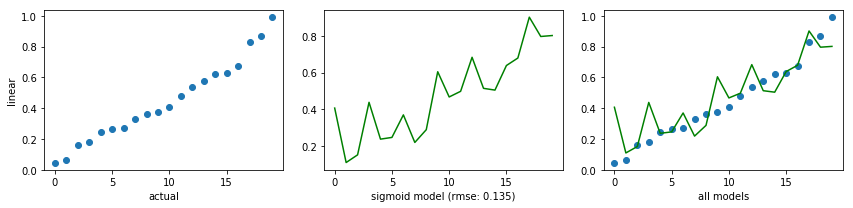

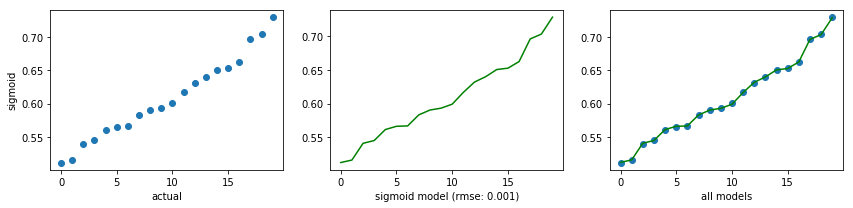

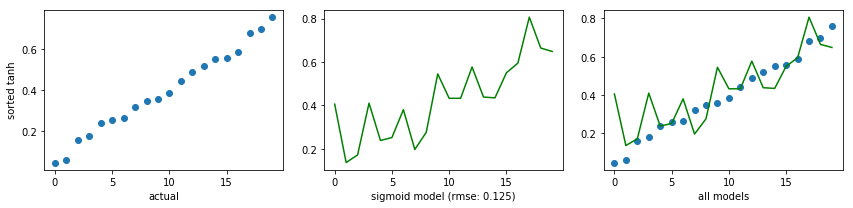

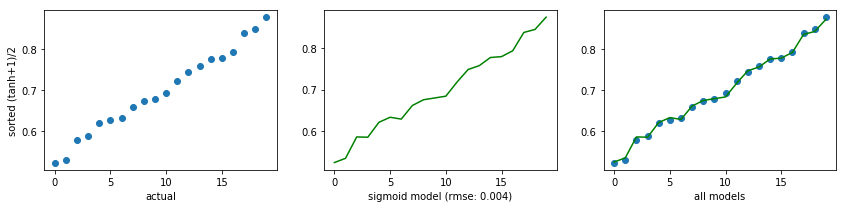

In [15]:
X = np.random.rand(20, 5)
T = sigmoid(X[:, 0:1])
order = np.argsort(T, axis=0).reshape(-1)
test_sigmoid('linear', X[order], X[order, 0:1])
test_sigmoid('sigmoid', X[order], sigmoid(X[order, 0:1]))
test_sigmoid('sorted tanh', X[order], np.tanh(X[order, 0:1]))
test_sigmoid('sorted (tanh+1)/2', X[order], (np.tanh(X[order, 0:1])+1)/2)

Here is a sample of it fitting different models. It fits the sigmoid model perfectly, which is good. It roughly fits the linear and tanh models too, so it seems to be functioning. Yay math!

This function and tanh look pretty similar, so I don't know how useful it is to experiment with this more than I already have with tanh.

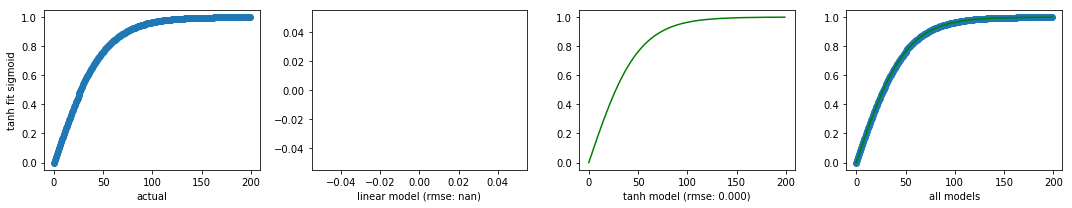

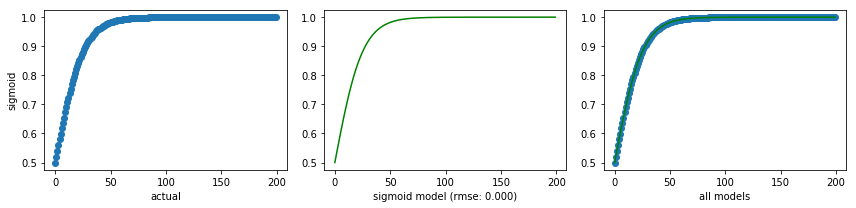

In [16]:
X = np.arange(200).reshape(-1, 1)/25
test('tanh fit sigmoid', X, 2*sigmoid(X)-1)
test_sigmoid('sigmoid', X, (np.tanh(X)+1)/2)

I don't know what happened to linear, but we see here that $2 sigmoid(x)-1 = \tanh(2 x)$
$$
\begin{align*}
2 sigmoid(x)-1 &= \frac{2}{1+e^{-x}}-1 \\
&= \frac{2}{1+e^{-x}} - \frac{1+e^{-x}}{1+e^{-x}} \\
&= \frac{2 - 1 - e^{-x}}{1+e^{-x}} \\
&= \frac{1 - e^{-x}}{1+e^{-x}} \\
&= \frac{e^{x/2} - e^{-x/2}}{e^{x/2} + e^{-x/2}} \\
&= \tanh\big(\frac{z}{2}\big)
\end{align*}
$$

The weights converge to the $\frac{z}{2}$, and then the models fit each other exactly after the transformation. That is why we see a RSME of $0.00$ for $200$ samples. We should expect the weight matrix to be $0.5$.

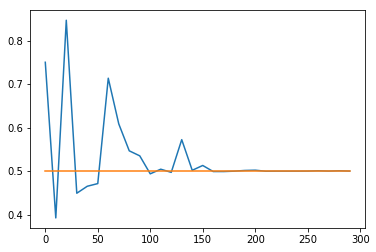

In [17]:
X = np.arange(200).reshape(-1, 1)/25
iters = []
x = []
for i in range(30):
    iter = i*10
    model = train_tanh(X, 2*sigmoid(X)-1, 0.001, iter)
    iters.append(iter)
    x.append(model[0][0])

plt.plot(iters, x)
plt.plot(iters, [0.5 for _ in x]);

You can see after about 200 iterations, it converges to 0.5 like we expected.